# Notebook performing `Machine Learning` Pipeline of a classifier on UNB's `NSL-KDD` dataset

This notebook is used to demonstrate a possible pipeline through the `Machine Learning` process of a classifier. In this case, we are using `NSL-KDD` dataset. In general the `ML` pipeline consists of the following steps:

1. Read the data
2. Analyse the dataset 

    &rightarrow; does it contain NaN's 
    
    &rightarrow; filling strategy (keep in mind to distinguish between train and test dataset with filling strategy &rightarrow; do not fill the test set with information gained in train set)
    
    &rightarrow; Feature Transformation. Make sure that all Features are numeric! If using a Neural Network (here with Triplet Loss for Feature Reduction), scale data in range [0 - 1]

    &rightarrow; Drop features that have the same value over all samples
3. Data / Feature Reduction

    &rightarrow; reduce the amount of data to increase ML algorithms performance
    
    &rightarrow; find a clever transformation (PCA / NN with Triplet Loss + PCA / LDA) to increase ML algorithm accuracy!
    
    &rightarrow; visualize / evaluate success on two dimensions (maybe 1 for LDA depending on number of classes)
4. Simple Classifier (KNN / SVM) depending on success of step 4 and task itself (anomaly detection, Computer Vision, time series)

    &rightarrow; KNN with high train speed but lower prediction speed, SVM takes much longer but has faster prediction times
    
    &rightarrow; NN only for Computer Vision task (=CNN), maybe time series
    
    &rightarrow; for Anomaly Detection use maybe Autoencoder (overkill?) or IsolationForest, maybe simple clustering?
5. Evaluation of classification success

    &rightarrow; via Confusion Matrix / above mentioned data plotting (after Feature Reduction) / different metrices

<br/><br/>
### 1. Data / Module Import

In [1]:
## Import of the used dataset
from sklearn.datasets import load_breast_cancer
## model set-up (here triplet loss), data manipulation
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter
from tensorflow.keras.layers import *
import tensorflow as tf
## later used classifier
from sklearn.svm import SVC
## self written helper modules
from scripts.model import NN
from scripts.utils import *
## load later used classifier and data
clf = SVC()
## download the data directly from this github repo, following https://medium.com/@alik604/predicting-the-nsl-kdd-data-set-with-98-accuracy-240a7a245c9d
train = pd.read_csv('https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain%2B.csv', header=None)
test = pd.read_csv('https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTest%2B.csv', header=None)
data = pd.concat([train, test])
## following (https://colab.research.google.com/drive/15L29IKGf-7JEvcSIC4FeOEcps5_Jn8hD#scrollTo=xcmNZAzs_Svh) this are the column names - not really needed
columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 
          'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 
          'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 
          'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 
          'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 
          'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'Label', 'difficulty_level']
## set columns
data.columns = columns

**take subsample of whole dataset with the most common labels**

In [2]:
num_labels = 10

labels = data.loc[:, "Label"]
counted_labels = Counter(labels)
keep_labels = []
for i, (label, counts) in enumerate(counted_labels.most_common()):
    if i < num_labels:
        keep_labels.append(label)
    else:
        break
print(f'original number of samples is {data.shape[0]}')
data = pd.concat([data[data["Label"] == label] for label in keep_labels])
print(f'number of samples after reducing to only the 12 most common is {data.shape[0]}')
print(counted_labels.most_common(num_labels))

original number of samples is 148516
number of samples after reducing to only the 12 most common is 142592
[('normal', 77053), ('neptune', 45871), ('satan', 4368), ('ipsweep', 3740), ('smurf', 3311), ('portsweep', 3088), ('nmap', 1566), ('back', 1315), ('guess_passwd', 1284), ('mscan', 996)]


**tackle distribution shift**

class appearance is highly unbalanced! &rightarrow; more than 77k different `normal` samples, only ~ 900 `teardrop` samples. Two possible solutions:

1. reuse samples of minor classes multiple times &rightarrow; every `teardrop` sample gets used ~ 77 times &rightarrow; blowing up the dataset without gaining more information
2. only use as much samples as the smallest class contains &rightarrow; dataset only contains of ~ 12x900 = 10800 samples instead of 144460 &rightarrow; ~7.5% of data remains than possible

In [3]:
data = tackle_distribution_shift(data, "constrain")

**take X and y**

In [4]:
X = data.drop("Label", axis = 1)
y = data.loc[:,"Label"]

### 2. Analyse the dataset 

&rightarrow; does it contain NaN's 
    
&rightarrow; filling strategy (keep in mind to distinguish between train and test dataset with filling strategy &rightarrow; do not fill the test set with information gained in train set)
    
&rightarrow; Feature Transformation. Make sure that all Features are numeric! If using a Neural Network (here with Triplet Loss for Feature Reduction), scale data in range [0 - 1]

&rightarrow; Drop features that have the same value over all samples

**make sure all features are numeric**

In [5]:
X = encode_objects(X)
## must ordinal encode the labels
y = encode_objects(y, how = "ordinal")

**drop features with no information (which are the same over all samples)**

In [6]:
X = handle_uniques(X)
y = handle_uniques(y)

handle unique's': 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 342.39it/s]


**NaN Analysis / filling strategy / Feature Transformation**

make sure to handle train and test data seperately from each other to not give spurious information gained from test dataset into train dataset

In [7]:
X = check_numeric(X)
y = check_numeric(y)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.16, random_state = 42)
train_X = handle_nans(train_X, "mean")
train_y = handle_nans(train_y)
test_X = handle_nans(test_X, "mean")
test_y = handle_nans(test_y)

make all columns numerical: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.10it/s]


no NaN's inside data
no NaN's inside data
no NaN's inside data
no NaN's inside data


check whether data has still consistent shapes

In [8]:
assert train_X.shape[0] == train_y.shape[0], "train data shape not matching"
assert test_X.shape[0] == test_y.shape[0], "test data shape not matching"
assert train_X.shape[1] == test_X.shape[1], "Feature Lengths between train and test X not matching"
assert train_y.shape[1] == test_y.shape[1], "Feature Lengths between train and test y not matching"

train_X.shape, train_y.shape, test_X.shape, test_y.shape

((8366, 113), (8366, 1), (1594, 113), (1594, 1))

**scale data**

use two different scalers for both datasets!

In [9]:
scaler = StandardScaler()
scaler.fit(train_X)
train_X = scaler.transform(train_X)
test_X = scaler.transform(test_X)

### 3. Data / Feature Reduction

&rightarrow; reduce the amount of data to increase ML algorithms performance
    
&rightarrow; find a clever transformation (PCA / NN with Triplet Loss + PCA / LDA) to increase ML algorithm accuracy!
    
&rightarrow; visualize / evaluate success on two dimensions (maybe 1 for LDA depending on number of classes)


**set up the Feature Reduction algorithm**

In [10]:
def def_model():
    num_features = train_X.shape[1]
    model = tf.keras.Sequential()
    model.add(InputLayer(input_shape=(num_features)))
    model.add(Flatten())
    model.add(Dense(np.ceil(num_features/2).astype(int), activation='relu'))
    model.add(Dense(np.ceil(num_features/4).astype(int), activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(np.ceil(num_features/2).astype(int), activation='relu'))
#     model.add(Dropout(0.1))
    model.add(Dense(num_features, activation=None)) # No activation on final dense layer
    model.add(Lambda(lambda x: tf.math.l2_normalize(x, axis=1))) # L2 normalize embeddings
    print(model.summary())
    return model

**delete remainder**

make sure not have a `Mini-Mini-Mini` Batch. If the remaining Batch is too small, the `loss` goes to `NaN` (because of infinite big gradients)

In [11]:
batch_size = 32
train_remainder = train_X.shape[0] % batch_size
test_remainder = test_X.shape[0] % batch_size
if train_remainder > 0:
    train_X = train_X[:-train_remainder]
    train_y = train_y[:-train_remainder]
if test_remainder > 0:
    test_X = test_X[:-test_remainder]
    test_y = test_y[:-test_remainder]

**fit decided Feature Reduction algorithm**

In [12]:
model = def_model()
nn = NN(model, train_X, train_y, test_X, test_y, lr = 1e-3, batch_size = batch_size, epochs = int(1e2), patience = int(5e0), verbose = 1)
## train and predict NN
nn.train()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 113)               0         
_________________________________________________________________
dense (Dense)                (None, 57)                6498      
_________________________________________________________________
dense_1 (Dense)              (None, 29)                1682      
_________________________________________________________________
dropout (Dropout)            (None, 29)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 57)                1710      
_________________________________________________________________
dense_3 (Dense)              (None, 113)               6554      
_________________________________________________________________
lambda (Lambda)              (None, 113)               0

**transform data (show different results for different strategies)**

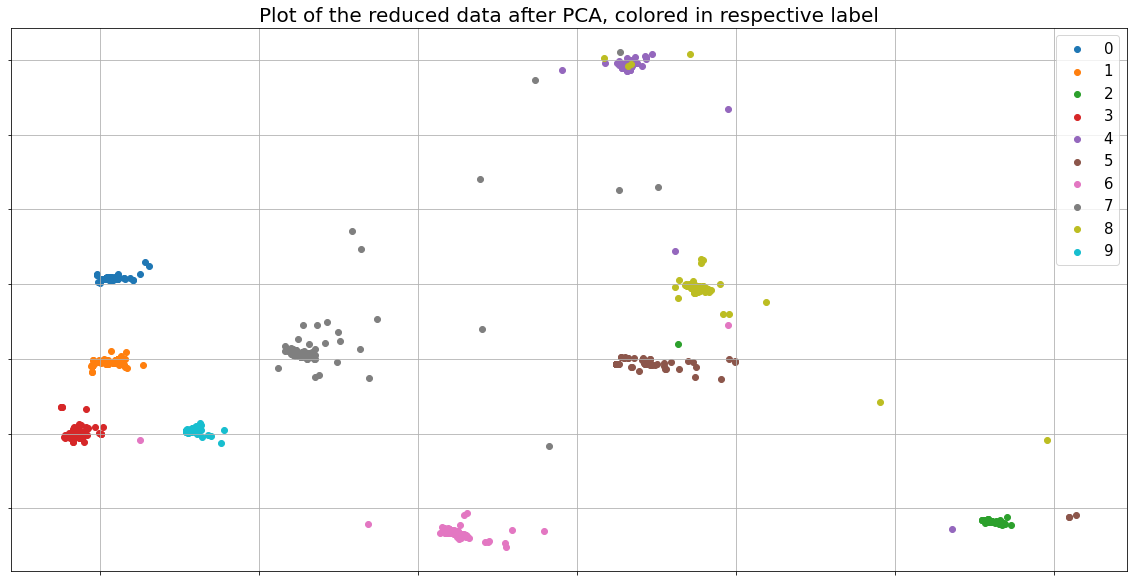

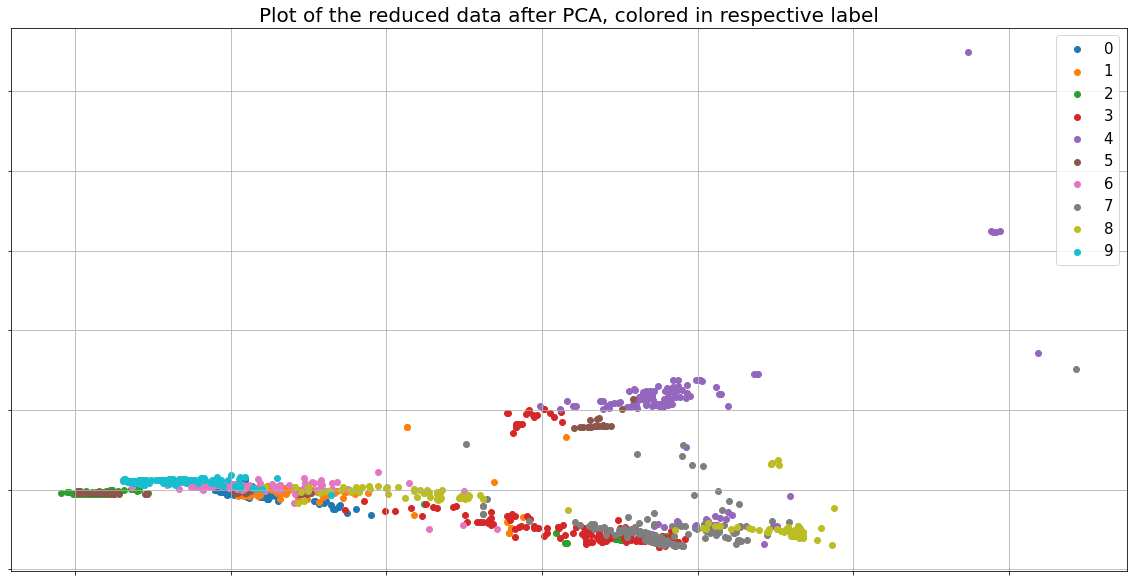

In [13]:
## transform data with Triplet Loss NN and PCA
X = nn.predict(test_X)
y = test_y
X_new, y = pca(X, y)
## transform data with a PCA
X_new_original, y_original = pca(test_X, test_y)

## plot result of NN + Triplet Loss + PCA
plot_reduced_data(X_new, y)
## plot result of PCA
plot_reduced_data(X_new_original, y_original)

### 4. Simple Classifier (KNN / SVM) depending on success of step 4 and task itself (anomaly detection, Computer Vision, time series)

&rightarrow; KNN with high train speed but lower prediction speed, SVM takes much longer but has faster prediction times
    
&rightarrow; NN only for Computer Vision task (=CNN), maybe time series
    
&rightarrow; for Anomaly Detection use maybe Autoencoder (overkill?) or IsolationForest, maybe simple clustering?
### 5. Evaluation of classification success

c:\python36\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Acc: 98.31%
Precision: 0.98
Recall: 0.98
F1 score: 0.98


c:\python36\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Acc: 69.14%
Precision: 0.74
Recall: 0.70
F1 score: 0.69


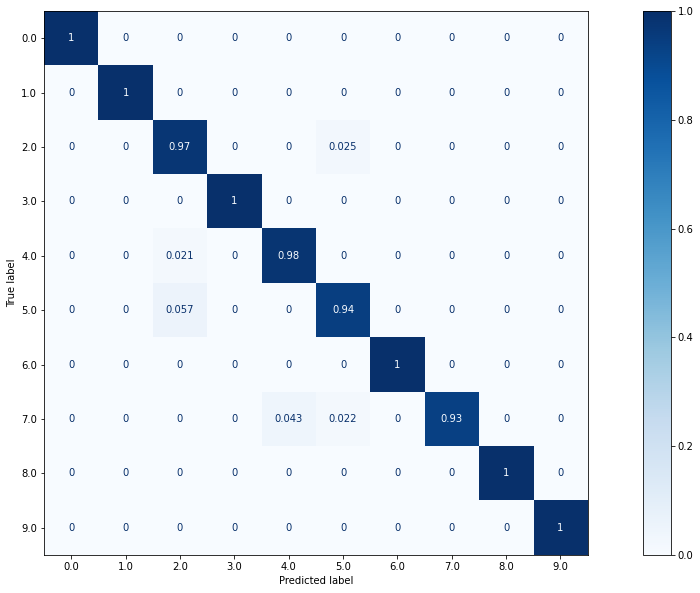

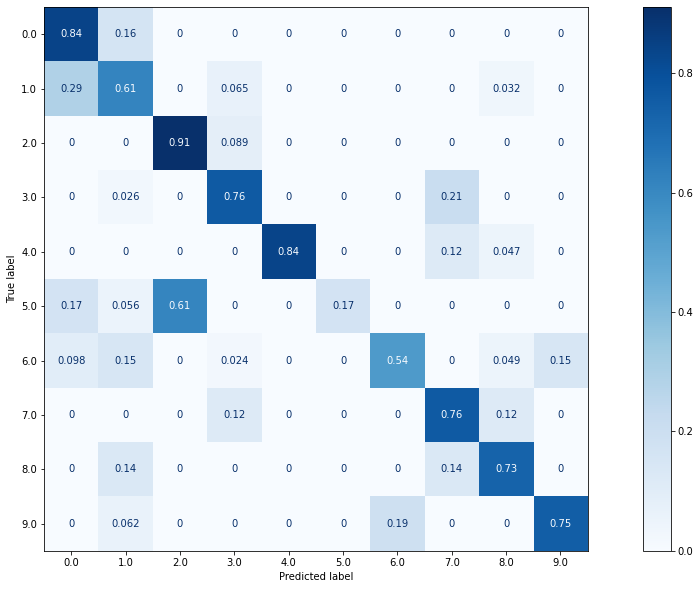

In [14]:
## evaluate NN + Triplet Loss + PCA
evaluate_model(clf, X_new, y)
## evaluate PCA
evaluate_model(clf, X_new_original, y_original)